In [1]:
import torch
import torch.nn as nn
import math

In [2]:
class ConvModel(nn.Module):
    def __init__(
        self, 
        in_channels: int = 3, 
        hidden_channels: int = 64, 
        out_channels: int = 512,
        kernel_size: int = 3):
        super().__init__()
        # Conv & Normalization
        self.conv1 = nn.Conv2d(in_channels, hidden_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(hidden_channels, hidden_channels*2, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv3 = nn.Conv2d(hidden_channels*2, out_channels, kernel_size=kernel_size, padding=kernel_size//2)

        self.norm1 = nn.BatchNorm2d(hidden_channels)
        self.norm2 = nn.BatchNorm2d(hidden_channels*2)
        self.norm3 = nn.BatchNorm2d(out_channels)
        
    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        # Conv1
        # [Batch, Channel, Height, Width]
        hidden_states = self.conv1(hidden_states)
        hidden_states = self.norm1(hidden_states)
        hidden_states = torch.relu(hidden_states)
        # Conv2
        hidden_states = self.conv2(hidden_states)
        hidden_states = self.norm2(hidden_states)
        hidden_states = torch.relu(hidden_states)
        # Conv3
        hidden_states = self.conv3(hidden_states)
        hidden_states = self.norm3(hidden_states)
        hidden_states = torch.relu(hidden_states)

        #b, c, h, w = hidden_states.shape
        # [B, C, H*W]
        #hidden_states = hidden_states.view(b, c, h*w)
        # [B, H*W, C]
        #hidden_states = hidden_states.transpose(1, 2)
        return hidden_states

In [3]:
def get_rotary_embeddings(img_seq_len, inv_freq, device):
    t = torch.arange(img_seq_len, device=device).type_as(inv_freq)
    freqs = torch.einsum('i,j->ij', t, inv_freq)
    # [img_seq_len, head_dim//2]
    cos = freqs.cos()
    sin = freqs.sin()
    return cos, sin

def apply_rotary_embeddings(hidden_states, cos, sin):
    # [Batch, NumHead, HeadDim//2]
    x_real = hidden_states[..., ::2]
    x_fake = hidden_states[..., 1::2]
    x_out_real = x_real * cos - x_fake * sin
    x_out_fake = x_real * sin + x_fake * cos
    out = torch.stack([x_out_real, x_out_fake], dim=-1).flatten(-2)
    return out

In [4]:
class MultiHeadCrossAttention(nn.Module):
    def __init__(
        self, 
        dim_model: int = 512,
        num_heads: int = 8,
        dropout: float = 0.1):
        super().__init__()
        self.dim_model = dim_model
        self.num_heads = num_heads
        assert dim_model // num_heads, f"`dim_model` must be divisible by `num_heads` but got {dim_model=} and {num_heads=}"
        self.head_dim = dim_model // num_heads # 64
        
        self.q_proj = nn.Linear(dim_model*2, dim_model)
        self.k_proj = nn.Linear(dim_model, dim_model)
        self.v_proj = nn.Linear(dim_model, dim_model)
        self.o_proj = nn.Linear(dim_model, dim_model*2)        

        self.pre_q_norm = nn.LayerNorm(dim_model*2)
        self.pre_kv_norm = nn.LayerNorm(dim_model)
        self.post_attn_norm = nn.LayerNorm(dim_model*2)

        self.dropout = nn.Dropout(dropout)

        # RoPE
        inv_freq = 1.0 / (10000 ** (torch.arange(0, self.head_dim, 2).float() / self.head_dim))
        self.register_buffer("inv_freq", inv_freq)

    def forward(self, query: torch.Tensor, key_value: torch.Tensor, rope: bool=True) -> torch.Tensor:
        """
            query: [Batch, Channel, Height*Width]
            key_value: [Batch, Height*Width, HeadDim]
        """
        batch_size = query.size(0)
        # Channel      
        query_seq_len  = query.size(1)
        # Height*Width
        kv_seq_len = key_value.size(1)

        # [B, C, H*W] -> [2, 3, 1024]
        query = self.pre_q_norm(query)
        # [B, H*W, D_M] -> [2, 1024, 64]
        key_value = self.pre_kv_norm(key_value)

        # [B, C, D_M]
        q = self.q_proj(query)
        
        # [B, H*W, D_M] 
        k = self.k_proj(key_value)
        v = self.v_proj(key_value) 

        # Prepare for MultiHeadAttention
        # [B, C, D_M] -> [B, QSL, NH, HD]
        # [2, 3, 512] -> [2, 3, 8, 64]
        q = q.view(batch_size, query_seq_len, self.num_heads, self.head_dim)

        # [B, H*W, D_M] -> [B, KVSL, NH, HD]
        # [2, 1024, 512] -> [2, 1024, 8, 64]
        k = k.view(batch_size, kv_seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, kv_seq_len, self.num_heads, self.head_dim)

        # RoPE
        if rope:
            max_seq_len = max(query_seq_len, kv_seq_len)
            cos, sin = get_rotary_embeddings(max_seq_len, inv_freq=self.inv_freq, device=q.device)       
            q = q.transpose(1, 2)
            k = k.transpose(1, 2)
            for h in range(self.num_heads):
                q[:, h] = apply_rotary_embeddings(q[:, h], cos[:query_seq_len], sin[:query_seq_len])
                k[:, h] = apply_rotary_embeddings(k[:, h], cos[:kv_seq_len], sin[:kv_seq_len])

        k = k.transpose(-2, -1)
        v = v.transpose(1, 2)

        # MultiHeadAttention
        # [Batch, NumHeads, QuerySeqLen, HeadDim] @ [Batch, NumHeads, HeadDim, KVSeqLen]
        # [Batch, NumHeads, QuerySeqLen, KVSeqLen]
        attn_scores = torch.matmul(q, k)
        attn_scores /= math.sqrt(self.head_dim)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        # [Batch, NumHeads, QuerySeqLen, KVSeqLen] @ [Batch, NumHeads, KVSeqLen, HeadDim]
        # [Batch, NumHeads, QuerySeqLen, HeadDim]
        output = torch.matmul(attn_probs, v)

        # [Batch, QuerySeqLen, NumHeads, HeadDim]
        output = output.transpose(1, 2).contiguous()
        # [Batch, QuerySeqLen, DimModel]
        output = output.view(batch_size, query_seq_len, self.dim_model)
        # [Batch, QuerySeqLen, DimModel]
        output = self.o_proj(output)
        
        # Residual
        output = query + self.dropout(output)
        output = self.post_attn_norm(output)
        return output

## RoPE Difference between Cross and Vanilla Attention

* My Vanilla Attention had:
```python
# Shape: [Batch, SeqLen, HeadDim]
q[:, :, h] = apply_rotary_embeddings(q[:, :, h], cos, sin)
```

* but Cross Attention has:
```python
# Shape: [Batch, SeqLen, HeadDim]
q[:, h] = apply_rotary_embeddings(q[:, h], cos[:query_seq_len], sin[:query_seq_len])
k[:, h] = apply_rotary_embeddings(k[:, h], cos[:kv_seq_len], sin[:kv_seq_len])
```

- That's because in Vanilla Attention all Q, K and V have same sequence length, but in cross attention Q and KV have different sequence lengths since we get Q from different source.
- We get max_seq_len with `max_seq_len = max(query_seq_len, kv_seq_len)` and use it for `cos`&`sin`.
- Shape isn't an issue for `cos/sin` because they are created using `HeadDim`.
- After that its all the same


In [11]:
from einops import rearrange

image = torch.randn(2, 3, 32, 32)
text_features = torch.randn(2, 32*32, 512)

print(f"Image Input Shape: {image.shape}")
print(f"Text Input Shape: {text_features.shape}\n--------\n")

c1 = ConvModel(in_channels=3, hidden_channels=64, out_channels=512)
c2 = ConvModel(in_channels=512, hidden_channels=256, out_channels=64)
c3 = ConvModel(in_channels=64, hidden_channels=64, out_channels=3)

output1 = c1(image)
print(f"Conv1 Output Shape: {output1.shape}")
output2 = c2(output1)
print(f"Conv2 Output Shape: {output2.shape}")
output3 = c3(output2)
print(f"Conv3 Output Shape: {output3.shape}\n--------\n")

m1 = MultiHeadCrossAttention(dim_model=512, num_heads=8, dropout=0.1)
m2 = MultiHeadCrossAttention(dim_model=512, num_heads=8, dropout=0.1)
m3 = MultiHeadCrossAttention(dim_model=512, num_heads=8, dropout=0.1)

cross_attn_input = rearrange(output3, "b c h w -> b c (h w)")
print(f"MultiHeadCrossAttention Input Shape: {cross_attn_input.shape}")

out1 = m1(cross_attn_input, text_features)
print(f"Attn1 Output Shape: {out1.shape=}")
out2 = m2(out1, text_features)
print(f"Attn2 Output Shape: {out2.shape=}")
out3 = m3(out2, text_features)
print(f"Attn3 Output Shape: {out3.shape=}")

Image Input Shape: torch.Size([2, 3, 32, 32])
Text Input Shape: torch.Size([2, 1024, 512])
--------

Conv1 Output Shape: torch.Size([2, 512, 32, 32])
Conv2 Output Shape: torch.Size([2, 64, 32, 32])
Conv3 Output Shape: torch.Size([2, 3, 32, 32])
--------

MultiHeadCrossAttention Input Shape: torch.Size([2, 3, 1024])
Attn1 Output Shape: out1.shape=torch.Size([2, 3, 1024])
Attn2 Output Shape: out2.shape=torch.Size([2, 3, 1024])
Attn3 Output Shape: out3.shape=torch.Size([2, 3, 1024])


## Connect Everything

In [12]:
class ConvRoPeMultiHeadCrossAttentionModel(nn.Module):
    def __init__(
        self, 
        in_channels: int=3,
        hidden_channels: int = 64,
        out_channels: int=512, 
        dim_model: int=512, 
        num_heads: int=8, 
        dropout: float= 0.1
    ):
        super().__init__()
        assert out_channels == dim_model, f"`out_channels` must be equal to `dim_model` but got {out_channels=} and {dim_model=}"
        assert dim_model // num_heads, f"`dim_model` must be divisible by `num_heads` but got {dim_model=} and {num_heads=}"

        # Conv Layers
        self.conv1 = ConvModel(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels)
        self.conv2 = ConvModel(in_channels=out_channels, hidden_channels=out_channels//2, out_channels=hidden_channels)
        self.conv3 = ConvModel(in_channels=hidden_channels, hidden_channels=hidden_channels, out_channels=in_channels)
        
        # Cross-attention layers
        self.attn1 = MultiHeadCrossAttention(dim_model=dim_model, num_heads=num_heads, dropout=dropout)
        self.attn2 = MultiHeadCrossAttention(dim_model=dim_model, num_heads=num_heads, dropout=dropout)
        self.attn3 = MultiHeadCrossAttention(dim_model=dim_model, num_heads=num_heads, dropout=dropout)
        
        self.proj = nn.Linear(dim_model*2, dim_model)
        self.act = nn.ReLU()
    
    def forward(
            self, 
            image: torch.Tensor, 
            condition: torch.Tensor
        ) -> torch.Tensor:
        # 1. Conv Layers        
        image = self.conv1(image)
        image = self.conv2(image)
        image = self.conv3(image)
        print(image.shape)
        image = rearrange(image, "b c h w -> b c (h w)") #image.view(2, 3, 32*32) # Reshape for attention
        
        # 2. Apply cross-attention layers
        hidden_states = self.attn1(image, condition)
        hidden_states = self.attn2(hidden_states, condition)
        hidden_states = self.attn3(hidden_states, condition)
        
        # 3. Final projection and activation
        output = self.proj(hidden_states)
        output = self.act(output)
        
        return output  # [B, H*W, D]

In [13]:
model = ConvRoPeMultiHeadCrossAttentionModel()
image = torch.randn(2, 3, 32, 32)
text_features = torch.randn(2, 32*32, 512)

output = model(image, text_features)
print(output.shape)

torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 512])


In [22]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Parameters: {num_parameters:,}")
print(f"Trainable: {num_trainable_params:,}")

Parameters: 8,705,161
Trainable: 8,705,161


## Conv Layers and Attention

* In this part of the notebook I spent time to see what actually my model `see` on images.
* Its the same model as the one above, except cross attention.

In [9]:
class ConvRoPEMultiHeadAttention(nn.Module):
    def __init__(
        self, 
        d_model: int = 512, 
        num_heads: int = 8, 
        conv_channels: int = 64, 
        kernel_size: int = 3, 
        dropout: float = 0.1
    ):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads # 64
        
        # Conv & Normalization
        self.conv1 = nn.Conv2d(3, conv_channels, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv2 = nn.Conv2d(conv_channels, conv_channels*2, kernel_size=kernel_size, padding=kernel_size//2)
        self.conv3 = nn.Conv2d(conv_channels*2, d_model, kernel_size=kernel_size, padding=kernel_size//2)

        self.norm1 = nn.BatchNorm2d(conv_channels)
        self.norm2 = nn.BatchNorm2d(conv_channels*2)
        self.norm3 = nn.BatchNorm2d(d_model)

        # Attention
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.o_proj = nn.Linear(d_model, d_model)

        self.pre_attn_norm = nn.LayerNorm(d_model)
        self.post_attn_norm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

        # RoPE
        inv_freq = 1.0 / (10000 ** (torch.arange(0, self.head_dim, 2).float() / self.head_dim))
        self.register_buffer("inv_freq", inv_freq)

    def get_rotary_embeddings(self, seq_len, device):
        # [SeqLen] -> [1024]
        t = torch.arange(seq_len, device=device).type_as(self.inv_freq)
        # [SeqLen, HeadDim/2] -> [1024, 32]
        freqs = torch.einsum('i,j->ij', t, self.inv_freq)
        cos = freqs.cos()
        sin = freqs.sin()
        return cos, sin

    def apply_rotary_embeddings(self, hidden_states, cos, sin):
        x_real, x_fake = hidden_states[..., ::2], hidden_states[..., 1::2]
        x_out_real = x_real * cos - x_fake * sin
        x_out_fake = x_real * sin + x_fake * cos
        out = torch.stack([x_out_real, x_out_fake], dim=-1).flatten(-2)
        return out

    def process_image(self, x):
        # Conv1
        x = self.conv1(x)
        x = self.norm1(x)
        x = torch.relu(x)
        # Conv2
        x = self.conv2(x)
        x = self.norm2(x)
        x = torch.relu(x)
        # Conv3
        x = self.conv3(x)
        x = self.norm3(x)
        x = torch.relu(x)

        b, c, h, w = x.shape
        # [B, C, H*W]
        x = x.view(b, c, h*w)
        # [B, H*W, C]
        x = x.transpose(1, 2)
        return x
    
    def attention_block(self, x):
        x = self.pre_attn_norm(x)
        
        # [Batch, H*W, DimModel] | [2, 1024, 512]
        q = self.q_proj(x) 
        k = self.k_proj(x)
        v = self.v_proj(x)

        b, seq_len, c = x.shape

        # Prepare for MultiHeadAttention
        # [Batch, SeqLen, NumHeads, HeadDim] | [2, 1024, 8, 64]
        q = q.view(b, seq_len, self.num_heads, self.head_dim)
        k = k.view(b, seq_len, self.num_heads, self.head_dim)
        v = v.view(b, seq_len, self.num_heads, self.head_dim)

        # RoPE
        # [H*W, HeadDim/2]
        cos, sin = self.get_rotary_embeddings(seq_len, x.device)    
        
        # [Batch, SeqLen, NumHeads, HeadDim]
        for h in range(self.num_heads):
            q[:, :, h] = self.apply_rotary_embeddings(q[:, :, h], cos, sin)
            k[:, :, h] = self.apply_rotary_embeddings(k[:, :, h], cos, sin)
        
        # MultiHeadAttention
        # [Batch, SeqLen, NumHeads, HeadDim] @ [Batch, SeqLen, HeadDim, NumHeads]
        # -> [Batch, SeqLen, NumHeads, NumHeads]
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        
        # [Batch, SeqLen, NumHeads, NumHeads] @ [Batch, SeqLen, NumHeads, HeadDim]
        # -> [Batch, SeqLen, NumHeads, HeadDim]
        out = torch.matmul(attn, v)
        # [Batch, SeqLen, NumHeads*HeadDim]
        out = out.view(b, seq_len, self.d_model)
        out = self.o_proj(out)
        
        out = x + self.dropout(out)
        out = self.post_attn_norm(out)
        return out

    def forward(self, x):
        x = self.process_image(x)
        x = self.attention_block(x)
        return x

    def get_intermediate_features(self, x):
        features = {}

        # After Conv1+Norm1
        x1 = self.conv1(x)
        x1_norm = self.norm1(x1)
        features["conv1"] = x1.flatten()
        features["conv1_norm"] = x1_norm.flatten()
        x1 = torch.relu(x1_norm)

        x = self.process_image(x)
        features["pre_attention"] = x.flatten()

        x_norm = self.pre_attn_norm(x)
        features["attention_norm"] = x_norm.flatten()

        x = self.attention_block(x)
        features["output"] = x.flatten()
        
        return features

In [10]:
model = ConvRoPEMultiHeadAttention()

batch = 2
channel = 3
height = 32
width = 32
x = torch.randn(batch, channel, height, width)
output = model(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([2, 3, 32, 32])
Output shape: torch.Size([2, 1024, 512])


In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np

def load_and_preprocess_image(image_path, size=(32, 32)):
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor, image

class AttentionVisualizer:
    def __init__(self, model):
        self.model = model
        self.attention_maps = []
        
    def get_attention_maps(self, x):
        features = {}
        
        # Get conv features
        x1 = self.model.conv1(x)
        x1 = self.model.norm1(x1)
        features['conv1'] = x1
        x1 = torch.relu(x1)
        
        x2 = self.model.conv2(x1)
        x2 = self.model.norm2(x2)
        features['conv2'] = x2
        x2 = torch.relu(x2)
        
        x3 = self.model.conv3(x2)
        x3 = self.model.norm3(x3)
        features['conv3'] = x3
        x3 = torch.relu(x3)
        
        # Reshape for attention
        b, c, h, w = x3.shape
        x = x3.view(b, c, h*w).transpose(1, 2)
        
        # Get attention features
        x_norm = self.model.pre_attn_norm(x)
        q = self.model.q_proj(x_norm)
        k = self.model.k_proj(x_norm)
        v = self.model.v_proj(x_norm)
        
        # Reshape for multi-head attention
        b, seq_len, _ = x.shape
        q = q.view(b, seq_len, self.model.num_heads, self.model.head_dim)
        k = k.view(b, seq_len, self.model.num_heads, self.model.head_dim)
        v= v.view(b, seq_len, self.model.num_heads, self.model.head_dim)
        
        # Get attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(self.model.head_dim)
        attention = torch.softmax(scores, dim=-1)
        #! --
        output = torch.matmul(attention, v)
        #! --
        
        return features, attention, output, (h, w)

    def visualize(self, image_path, plot_original=True, plot_conv=True, plot_heads=True, plot_magnitude=True):
        image_tensor, original_image = load_and_preprocess_image(image_path)
        
        with torch.no_grad():
            features, attention, output, (h, w) = self.get_attention_maps(image_tensor)
        
        # Plot results
        fig = plt.figure(figsize=(20, 10))
        
        # Plot original image
        if plot_original:
            plt.subplot(2, 4, 1)
            plt.imshow(original_image)
            plt.title('Original Image')
            plt.axis('off')
        
        if plot_conv:
            # Plot conv feature maps (average across channels)
            for idx, (name, feat) in enumerate(features.items()):
                plt.subplot(2, 4, idx + 2) # 2, 4, idx + 2
                feat_map = feat.mean(dim=1).squeeze().cpu()
                feat_map = (feat_map - feat_map.min()) / (feat_map.max() - feat_map.min() + 1e-8)
                plt.imshow(feat_map, cmap='viridis')
                plt.title(f'{name} Features')
                plt.axis('off')
        
        # Plot attention maps for different heads
        attention = attention.squeeze(0)  # Remove batch dimension
        output = output.squeeze(0)

        for head_idx in range(attention.shape[1]): #range(min(8, attention.shape[0])):
            if plot_heads:
                plt.subplot(8, 4, head_idx+17) # [2, 8, head_idx+9]
                attn_map = attention[head_idx].mean(0).reshape(int(np.sqrt(attention.shape[-1])), -1)
                attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
                plt.imshow(attn_map.cpu(), cmap='viridis')
                plt.title(f'Attention Head {head_idx}')
                plt.axis('off')
                plt.colorbar(fraction=0.046, pad=0.04)

            #! Output magnitudes
            if plot_magnitude:
                plt.subplot(8, 4, head_idx+25)
                out_map = output[:, head_idx].norm(dim=-1).reshape(h, w)
                out_map = out_map.cpu().numpy()
                out_map = (out_map - out_map.min()) / (out_map.max() - out_map.min() + 1e-8)
                plt.imshow(original_image, alpha=0.5)
                plt.imshow(out_map, cmap="hot", alpha=0.5)
                plt.title(f"Head {head_idx} Output Magnitude")
                plt.axis("off")
                plt.colorbar(fraction=0.046, pad=0.04)
    
        plt.tight_layout()

# Usage
def visualize_attention(image_path, plot_original=True, plot_conv=True, plot_heads=True, plot_magnitude=True):
    model = ConvRoPEMultiHeadAttention()
    model.eval()
    
    visualizer = AttentionVisualizer(model)
    visualizer.visualize(image_path, plot_original=plot_original, plot_conv=plot_conv, plot_heads=plot_heads, plot_magnitude=plot_magnitude)
    plt.show()

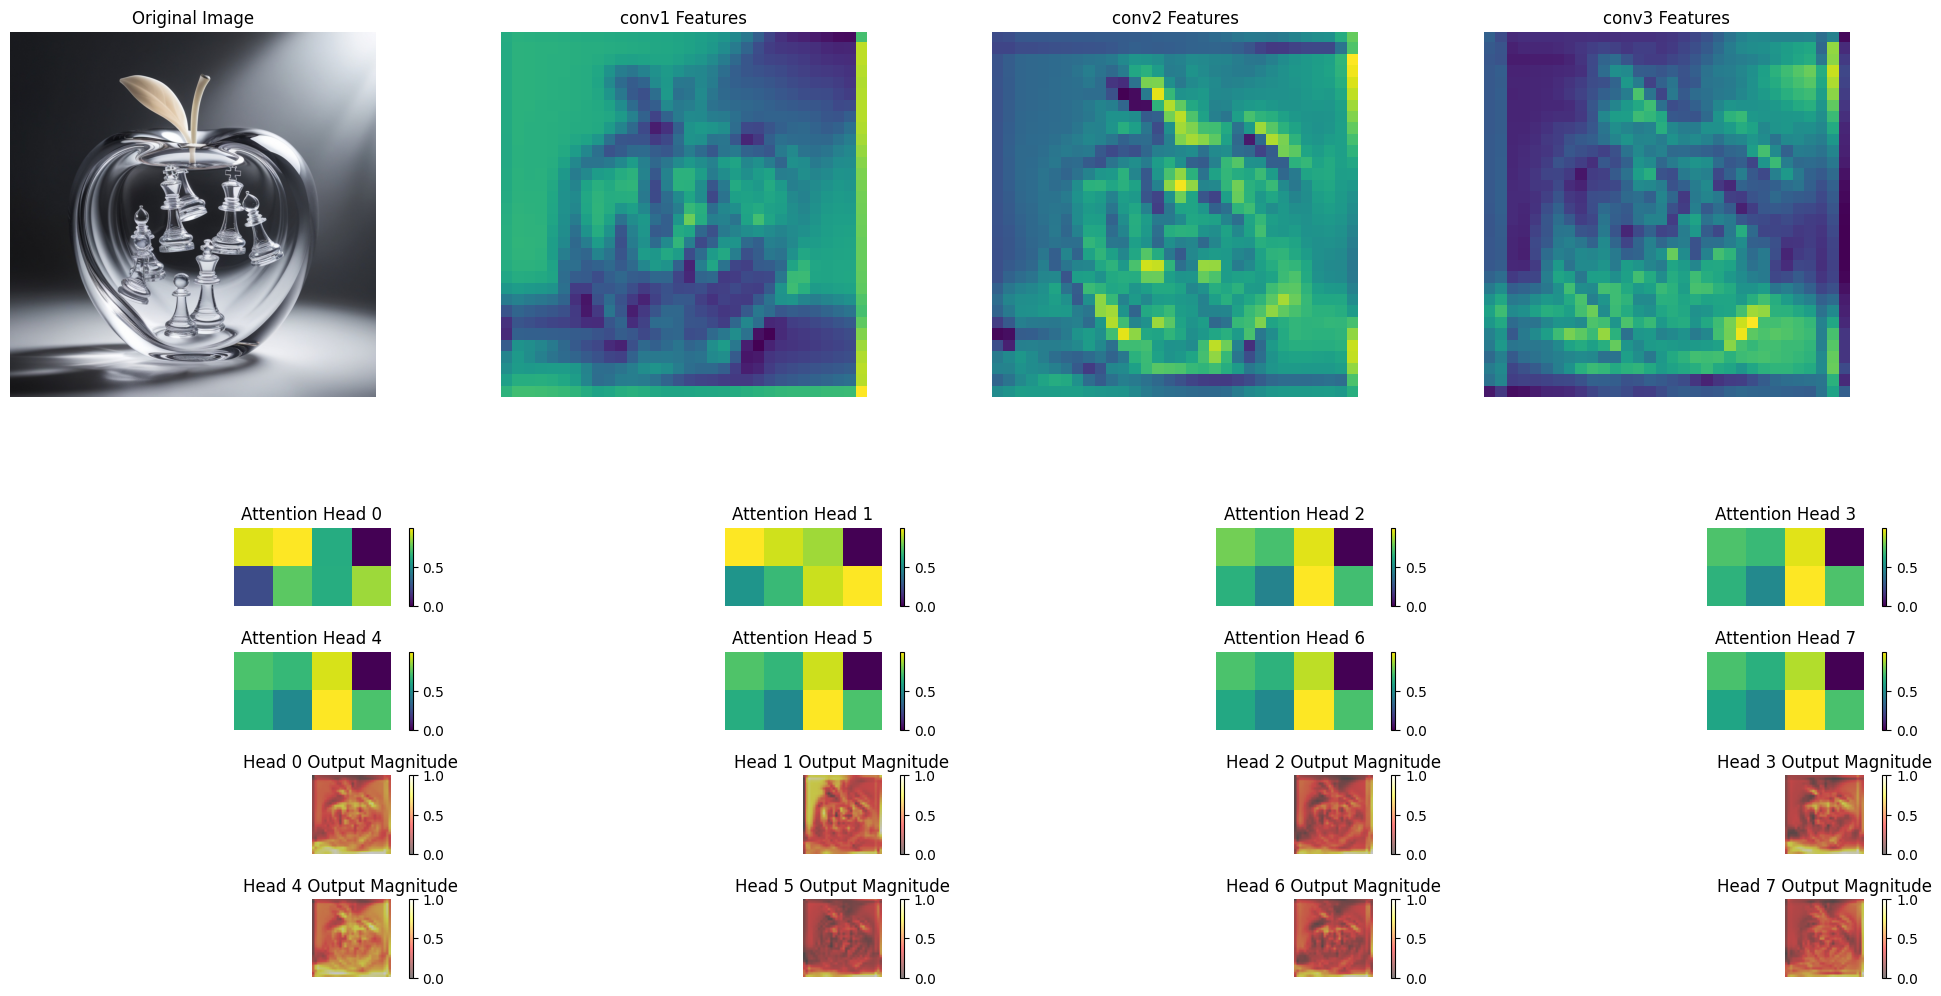

In [ ]:
img=r"../flux-apple/chess1.jpg"
visualize_attention(image_path=img)